# DNN: Taming Network Flexibility & Determining Prediction Uncertainty

In this notebook we study two aspects related to training Deep Artificial Neural Networks of DNNs.

- Overfitting
- Uncertainty of Predictions

The expressiveness of DNNs come from its complex architecture, i.e., large number of computational units or neurons. However, this extreme flexibility causes severe overfitting.

The two popular approaches to combat overfitting are:
- Weight Decay
- Dropout

In **weight decay** based approach we regularize the DNN by updating its loss/cost function to penalize the model in proportion to the size of the model weights. For implementing weight decay we usually use the $l_p$ regularizer, where $p$ is any positive integer starting from 1. Setting $p=1$ we get the $l_1$ regularizer, and for $p=2$ we get the $l_2$ regularizer.


In **Dropout regularization** technique at each iteration we drop every neuron temporarily with a probability $p$. It includes input layer neurons but excludes the output neurons. Here $p$ is a hyperparameter, which is known as the dropout rate. Its value is usually set between 10% to 50%.

Dropout regularization technique was proposed by Hinton in 2012:
http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf


## Reducing Overfitting via Dropout

In this notebook, we investigate the **effect of Dropout regularization** technique. We give two reasons for its effectiveness as a regularizer.

- Due to random dropout, the neurons become independent as they cannot co-adapt with their neighboring neurons. Thus, each individual neuron learns to perform effectively on its own. As a result, they become more immune to the changes in small changes in the input. When a Droput trained DNN is fed with unseen test data, it generallizes better.

- An interesting aspect of Dropout is that at each iteration it creates a unique DNN. Because every neuron could be either on or off. Note that for $N$ neurons there are $2^N$ possible networks. Thus, it is unlikely that two networks at two iterations would be the same. As a result, at the end of training the network for $t$ iterations, there would be an ensemble of $t$ unique networks. Thus, the resulting network can be seen as an averaging ensemble of all these networks. The inherent diversity of the ensemble improves the generalization performance.


## Capturing the Uncertainty of Predictions

Another, more profound, effect of Dropout is that it can be used to capture a model's uncertainty. The following paper shows the connection between Dropout and approximate Bayesian inference:

http://proceedings.mlr.press/v48/gal16.pdf

In this paper, a Monte Carlo (MC) Dropout technique is introduced to **improve the uncertainty measure** of any trained dropout model. The MC Dropout technique is super simple as we don't need to retrain the model after training it with Dropout.

Let's briefly discuss how MC Dropout provides a measure of the model’s uncertainty.

Suppose we have trained a DNN using Dropout. Then, we make $m$ number of predictions on the test set by keeping the Dropout layer active. Due to the Dropout property of the trained model, we will get $m$ different predictions for the same test input. We stack these predictions and compute their average. Thus, for a 10-class classification problem, prediction for a single test input will be averaged over $m$ predictions for 10 different classes. It will generate better probability estimates of the classes. The Monte Carlo estimate is generally more reliable than the result of a single prediction with dropout off. 

The MC estimates generate a lot of variance in the probability estimates. Thus it could be used to create risk-sensitive systems such as for financial or medical problems. 


## Dataset

To investigate the regularization and Bayesian property of Dropout, we use the Fashion MNIST dataset. It has the exact same format as MNIST (70,000 gray-scale images of 28 × 28 pixels each, with 10 classes). The images represent fashion items rather than handwritten digits. Thus, each class is more diverse, making the problem significantly more challenging than MNIST.


## DNN Architecture

We use a simple DNN architecture consisting of two hidden layers with 300 and 100 neurons, respectively.


## Experiments

We perform the following experments. In experiments 2 to 6 we apply Dropuout in all hidden layers and increase the dropout rate gradually. In experiment 7, the Dropout is only applied to the last hidden layer. We use the best dropout rate 0.4 (found experimentally from experiments 2 to 6). 

- Experiment 1: No Dropout
- Experiment 2: Dropout: p = 0.1
- Experiment 3: Dropout: p = 0.2
- Experiment 4: Dropout: p = 0.3
- Experiment 5: Dropout: p = 0.4
- Experiment 6: Dropout: p = 0.5
- Experiment 7: Last Hidden Layer Dropout: p = 0.4


In the last section of this notebook, we implement the MC Dropout and compare the uncertainty in its predictions with that of the plain Dropout model.

In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from scipy.stats import entropy

from functools import partial

import tensorflow as tf
from tensorflow import keras

## Load Data

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()


X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]
X_test = X_test / 255.


print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)



Shape of Training Samples:  (55000, 28, 28)
Shape of Training Labels:  (55000,)

Shape of Validation Samples:  (5000, 28, 28)
Shape of Validation Labels:  (5000,)

Shape of Testing Samples:  (10000, 28, 28)
Shape of Testing Labels:  (10000,)

Data type:  float32
Label type:  uint8


## Create Class Names

We create understandable text labels for each class.

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Display a Training Data with its Label

Class Name:  Coat


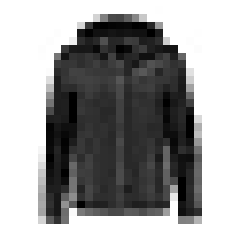

In [4]:
print("Class Name: ", class_names[y_train[0]])

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

## Display a Small Subset of Training Data with Labels 

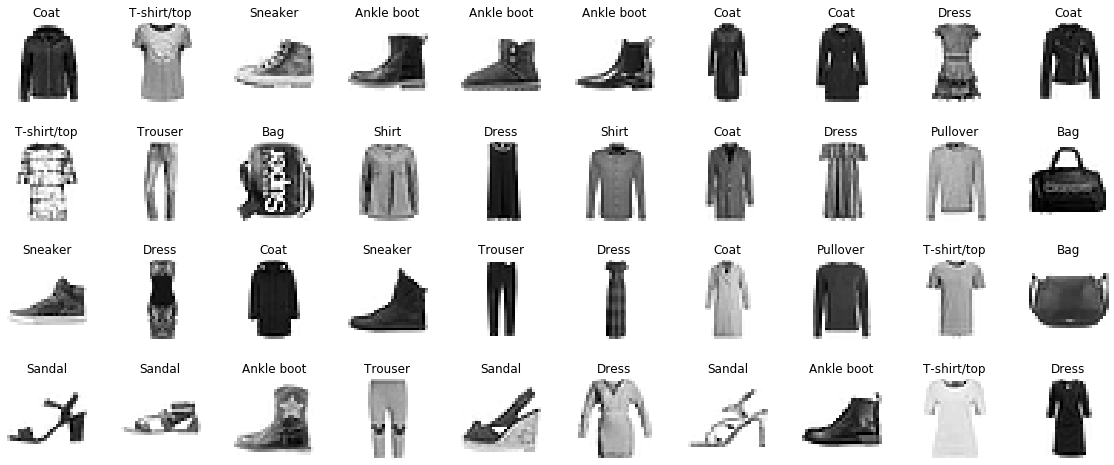

In [5]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Functions for Various Learning Curves & Computing Training Time

In [6]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''

def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
'''
Function for Plotting Learning Rate and Momentum
'''      
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()
    
    
# plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()
    

'''
Function to convert training time in seconds into hour-minute-second
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## A Class to Store the Changing Loss and Learning Rates at Each Epoch

In [7]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Experiment 1: No Dropout

We train the DNN without Dropout regularization.

In [8]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


'''
We use Python’s functools.partial() function to create a thin wrapper for the commonly used layers
with some default argument values.
'''
RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_No_Dropout"
model_name_format = "MNIST_Fashion_No_Dropout.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_No_Dropout = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()


duration_MNIST_Fashion_No_Dropout_sec = t1-t0
duration_MNIST_Fashion_No_Dropout = convertTime(duration_MNIST_Fashion_No_Dropout_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_No_Dropout)
print("\n")


model.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 72us/sample - loss: 0.6982 - accuracy: 0.7692 - val_loss: 0.5314 - val_accuracy: 0.8168
Epoch 2/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4832 - accuracy: 0.8310 - val_loss: 0.4535 - val_accuracy: 0.8462
Epoch 3/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4373 - accuracy: 0.8463 - val_loss: 0.4287 - val_accuracy: 0.8526
Epoch 4/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4122 - accuracy: 0.8551 - val_loss: 0.3897 - val_accuracy: 0.8684
Epoch 5/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3930 - accuracy: 0.8621 - val_loss: 0.3996 - val_accuracy: 0.8608
Epoch 6/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3774 - accuracy: 0.8653 - val_loss: 0.3701 - val_accuracy: 0.8734
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1501 - accuracy: 0.9473 - val_loss: 0.3064 - val_accuracy: 0.8934
Epoch 56/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1484 - accuracy: 0.9482 - val_loss: 0.3005 - val_accuracy: 0.8984
Epoch 57/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1455 - accuracy: 0.9489 - val_loss: 0.3233 - val_accuracy: 0.8898
Epoch 58/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1423 - accuracy: 0.9506 - val_loss: 0.3007 - val_accuracy: 0.9020
Epoch 59/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1419 - accuracy: 0.9506 - val_loss: 0.3293 - val_accuracy: 0.8914
Epoch 60/100
55000/55000 [==============================] - 3s 62us/sample - loss: 0.1380 - accuracy: 0.9518 - val_loss: 0.3061 - val_accuracy: 0.8982
Epoch 00060: early stopping

Training Time:   3 min 27 s


CPU times: user 7min 33s, sys: 1min

Epochs:  60

MNIST_Fashion_No_Dropout Test Accuracy: 0.889
MNIST_Fashion_No_Dropout Test Loss: 0.328

Test Confusion Matrix:
[[877   2  17  17   4   2  72   1   8   0]
 [  3 962   1  25   4   0   4   0   1   0]
 [ 25   0 843  12  57   1  55   0   7   0]
 [ 25   5  16 907  21   0  21   0   5   0]
 [  2   1 122  40 783   2  48   0   2   0]
 [  1   0   0   1   0 963   0  20   2  13]
 [140   0  95  25  64   0 667   0   9   0]
 [  0   0   0   0   0  16   0 963   1  20]
 [  9   0   1   6   1   3   7   6 967   0]
 [  0   0   0   0   0   7   1  36   0 956]]


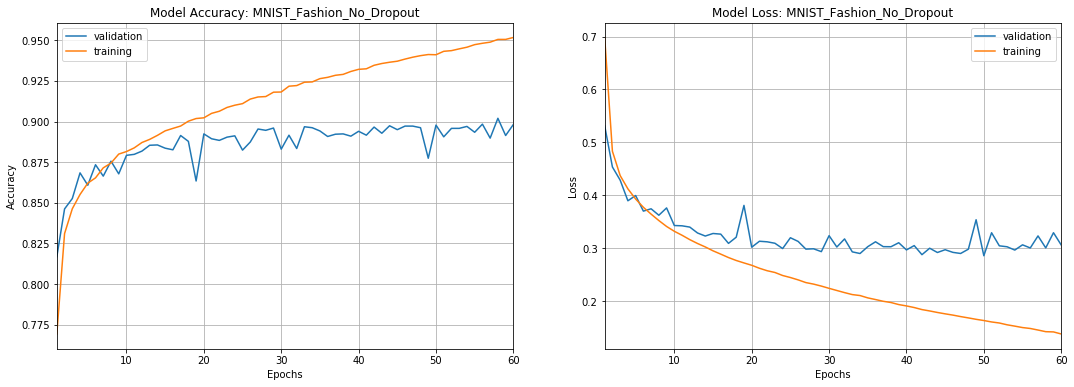

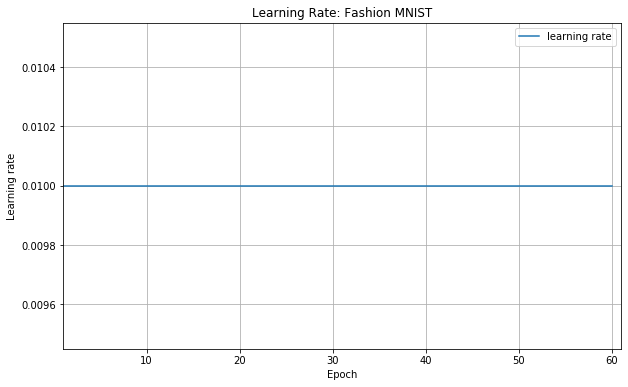

In [9]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_No_Dropout = len(history_MNIST_Fashion_No_Dropout.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_No_Dropout)

test_loss_MNIST_Fashion_No_Dropout, test_accuracy_MNIST_Fashion_No_Dropout = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_No_Dropout))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_No_Dropout))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_No_Dropout = model.predict(X_test)
y_test_predicted_No_Dropout = np.argmax(y_test_predicted_proba_No_Dropout, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_No_Dropout))


plot_learning_curves(history_MNIST_Fashion_No_Dropout, numOfEpochs_MNIST_Fashion_No_Dropout, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_No_Dropout, 
                   "Learning Rate: Fashion MNIST")

## Experiment 2: Dropout: p = 0.1

In [10]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_Dropout_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    keras.layers.Dropout(rate=0.1),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_Dropout_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_1"
model_name_format = "MNIST_Fashion_Dropout_1.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_1 = model_Dropout_1.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_1_sec = t1-t0
duration_MNIST_Fashion_Dropout_1 = convertTime(duration_MNIST_Fashion_Dropout_1_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_1)
print("\n")


model_Dropout_1.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.7782 - accuracy: 0.7371 - val_loss: 0.5228 - val_accuracy: 0.8196
Epoch 2/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5336 - accuracy: 0.8159 - val_loss: 0.4556 - val_accuracy: 0.8442
Epoch 3/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4764 - accuracy: 0.8330 - val_loss: 0.4160 - val_accuracy: 0.8568
Epoch 4/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4437 - accuracy: 0.8434 - val_loss: 0.3900 - val_accuracy: 0.8646
Epoch 5/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4188 - accuracy: 0.8521 - val_loss: 0.3780 - val_accuracy: 0.8666
Epoch 6/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3992 - accuracy: 0.8567 - val_loss: 0.3673 - val_accuracy: 0.8712
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1899 - accuracy: 0.9296 - val_loss: 0.2841 - val_accuracy: 0.8988
Epoch 56/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1864 - accuracy: 0.9325 - val_loss: 0.2759 - val_accuracy: 0.9036
Epoch 57/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1859 - accuracy: 0.9316 - val_loss: 0.2964 - val_accuracy: 0.8956
Epoch 58/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.1843 - accuracy: 0.9327 - val_loss: 0.2736 - val_accuracy: 0.9014
Epoch 59/100
55000/55000 [==============================] - 4s 72us/sample - loss: 0.1833 - accuracy: 0.9343 - val_loss: 0.2851 - val_accuracy: 0.8976
Epoch 60/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.1797 - accuracy: 0.9338 - val_loss: 0.2767 - val_accuracy: 0.9026
Epoch 61/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1785 - ac

Epochs:  68

MNIST_Fashion_Dropout_1 Test Accuracy: 0.892
MNIST_Fashion_Dropout_1 Test Loss: 0.308

Test Confusion Matrix:
[[843   2  15  12   3   1 116   0   8   0]
 [  3 973   0  18   2   0   3   0   1   0]
 [ 20   0 799  13  89   1  74   0   4   0]
 [ 24   9  10 902  26   0  25   0   4   0]
 [  1   1  72  34 836   0  53   0   3   0]
 [  0   0   0   0   0 966   0  18   0  16]
 [120   0  62  24  64   0 722   0   8   0]
 [  0   0   0   0   0  20   0 953   1  26]
 [  4   1   1   4   4   4   8   4 970   0]
 [  0   0   0   0   0   9   1  34   0 956]]


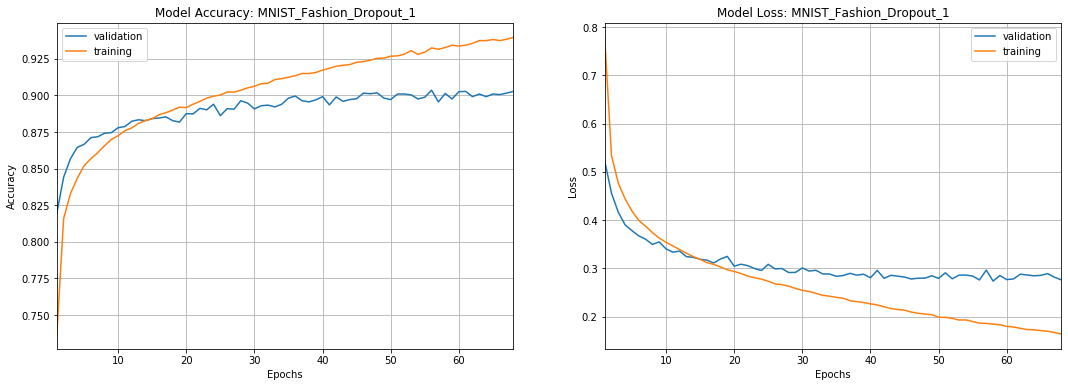

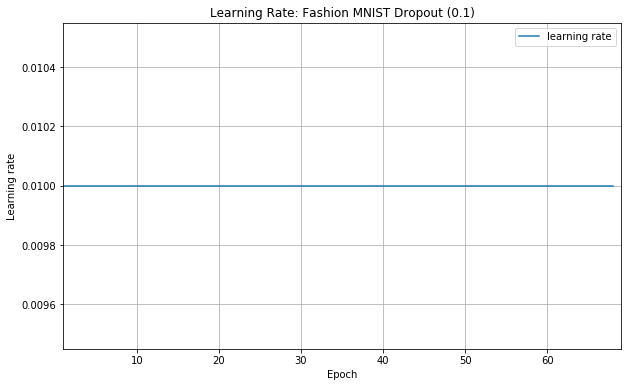

In [11]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_Dropout_1 = len(history_MNIST_Fashion_Dropout_1.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_Dropout_1)

test_loss_MNIST_Fashion_Dropout_1, test_accuracy_MNIST_Fashion_Dropout_1 = model_Dropout_1.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_Dropout_1))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_Dropout_1))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_Dropout_1 = model_Dropout_1.predict(X_test)
y_test_predicted_Dropout_1 = np.argmax(y_test_predicted_proba_Dropout_1, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_Dropout_1))


plot_learning_curves(history_MNIST_Fashion_Dropout_1, numOfEpochs_MNIST_Fashion_Dropout_1, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_Dropout_1, 
                   "Learning Rate: Fashion MNIST Dropout (0.1)")

## Experiment 3: Dropout: p = 0.2

In [12]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_Dropout_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    keras.layers.Dropout(rate=0.2),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_Dropout_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_2"
model_name_format = "MNIST_Fashion_Dropout_2.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_2 = model_Dropout_2.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_2_sec = t1-t0
duration_MNIST_Fashion_Dropout_2 = convertTime(duration_MNIST_Fashion_Dropout_2_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_2)
print("\n")


model_Dropout_2.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.8425 - accuracy: 0.7095 - val_loss: 0.5334 - val_accuracy: 0.8114
Epoch 2/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5699 - accuracy: 0.8035 - val_loss: 0.4653 - val_accuracy: 0.8392
Epoch 3/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5076 - accuracy: 0.8220 - val_loss: 0.4192 - val_accuracy: 0.8534
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4703 - accuracy: 0.8348 - val_loss: 0.3959 - val_accuracy: 0.8586
Epoch 5/100
55000/55000 [==============================] - 4s 71us/sample - loss: 0.4439 - accuracy: 0.8427 - val_loss: 0.3809 - val_accuracy: 0.8670
Epoch 6/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4220 - accuracy: 0.8483 - val_loss: 0.3717 - val_accuracy: 0.8686
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2196 - accuracy: 0.9198 - val_loss: 0.2769 - val_accuracy: 0.9030
Epoch 56/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2173 - accuracy: 0.9209 - val_loss: 0.2749 - val_accuracy: 0.9020
Epoch 57/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2153 - accuracy: 0.9202 - val_loss: 0.2843 - val_accuracy: 0.9014
Epoch 58/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2152 - accuracy: 0.9221 - val_loss: 0.2767 - val_accuracy: 0.9026
Epoch 59/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2138 - accuracy: 0.9209 - val_loss: 0.2800 - val_accuracy: 0.9026
Epoch 60/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2105 - accuracy: 0.9226 - val_loss: 0.2800 - val_accuracy: 0.9012
Epoch 61/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2096 - ac

Epochs:  66

MNIST_Fashion_Dropout_2 Test Accuracy: 0.890
MNIST_Fashion_Dropout_2 Test Loss: 0.309

Test Confusion Matrix:
[[851   2  24  26   4   1  81   0  11   0]
 [  2 968   1  22   3   0   3   0   1   0]
 [ 17   0 835  12  78   1  56   0   1   0]
 [ 18   5  15 905  28   0  26   0   3   0]
 [  1   1  95  35 806   0  61   0   1   0]
 [  0   0   0   1   0 963   0  21   0  15]
 [128   2  88  28  57   0 684   0  13   0]
 [  0   0   0   0   0  18   0 964   1  17]
 [  3   1   3   7   2   3   6   4 971   0]
 [  0   0   0   0   0   9   1  40   0 950]]


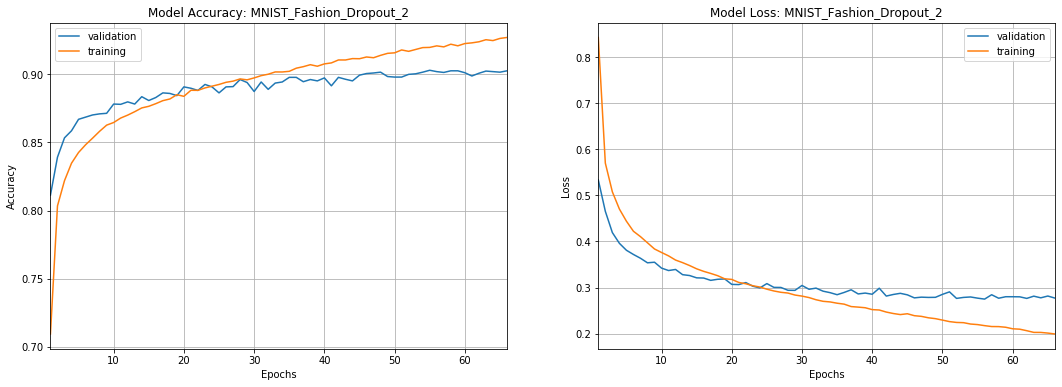

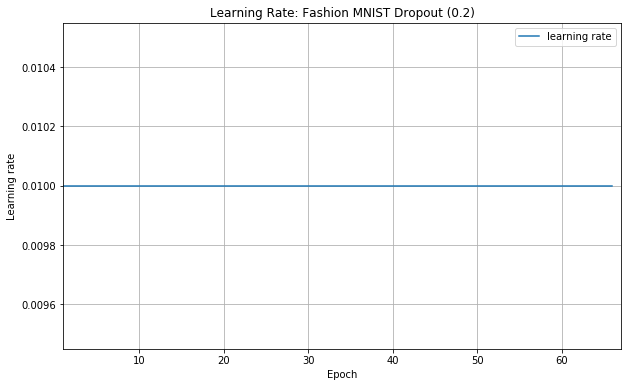

In [13]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_Dropout_2 = len(history_MNIST_Fashion_Dropout_2.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_Dropout_2)

test_loss_MNIST_Fashion_Dropout_2, test_accuracy_MNIST_Fashion_Dropout_2 = model_Dropout_2.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_Dropout_2))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_Dropout_2))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_Dropout_2 = model_Dropout_2.predict(X_test)
y_test_predicted_Dropout_2 = np.argmax(y_test_predicted_proba_Dropout_2, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_Dropout_2))


plot_learning_curves(history_MNIST_Fashion_Dropout_2, numOfEpochs_MNIST_Fashion_Dropout_2, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_Dropout_2, 
                   "Learning Rate: Fashion MNIST Dropout (0.2)")

## Experiment 4: Dropout: p = 0.3

In [14]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_Dropout_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    keras.layers.Dropout(rate=0.3),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_Dropout_3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_3"
model_name_format = "MNIST_Fashion_Dropout_3.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_3 = model_Dropout_3.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_3_sec = t1-t0
duration_MNIST_Fashion_Dropout_3 = convertTime(duration_MNIST_Fashion_Dropout_3_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_3)
print("\n")


model_Dropout_3.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 78us/sample - loss: 0.9114 - accuracy: 0.6811 - val_loss: 0.5527 - val_accuracy: 0.8022
Epoch 2/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.6119 - accuracy: 0.7884 - val_loss: 0.4803 - val_accuracy: 0.8330
Epoch 3/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5413 - accuracy: 0.8106 - val_loss: 0.4307 - val_accuracy: 0.8492
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5009 - accuracy: 0.8230 - val_loss: 0.4056 - val_accuracy: 0.8550
Epoch 5/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4720 - accuracy: 0.8344 - val_loss: 0.3910 - val_accuracy: 0.8608
Epoch 6/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4493 - accuracy: 0.8390 - val_loss: 0.3796 - val_accuracy: 0.8636
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2468 - accuracy: 0.9095 - val_loss: 0.2854 - val_accuracy: 0.8998
Epoch 56/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2458 - accuracy: 0.9099 - val_loss: 0.2783 - val_accuracy: 0.8996
Epoch 57/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2433 - accuracy: 0.9116 - val_loss: 0.2907 - val_accuracy: 0.8958
Epoch 58/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2424 - accuracy: 0.9107 - val_loss: 0.2818 - val_accuracy: 0.9004
Epoch 59/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2403 - accuracy: 0.9112 - val_loss: 0.2819 - val_accuracy: 0.8996
Epoch 60/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2398 - accuracy: 0.9119 - val_loss: 0.2845 - val_accuracy: 0.8988
Epoch 61/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2368 - ac

Epochs:  66

MNIST_Fashion_Dropout_3 Test Accuracy: 0.890
MNIST_Fashion_Dropout_3 Test Loss: 0.311

Test Confusion Matrix:
[[841   2  23  23   3   0  96   0  12   0]
 [  4 966   1  22   3   0   2   0   2   0]
 [ 13   0 836  13  80   1  57   0   0   0]
 [ 16   5  13 900  35   0  27   0   4   0]
 [  0   1  90  24 822   0  62   0   1   0]
 [  0   0   0   1   0 960   0  22   1  16]
 [114   1  92  32  62   0 686   0  13   0]
 [  0   0   0   0   0  12   0 969   1  18]
 [  3   1   2   8   2   2   6   4 972   0]
 [  0   0   0   0   0   6   1  41   0 952]]


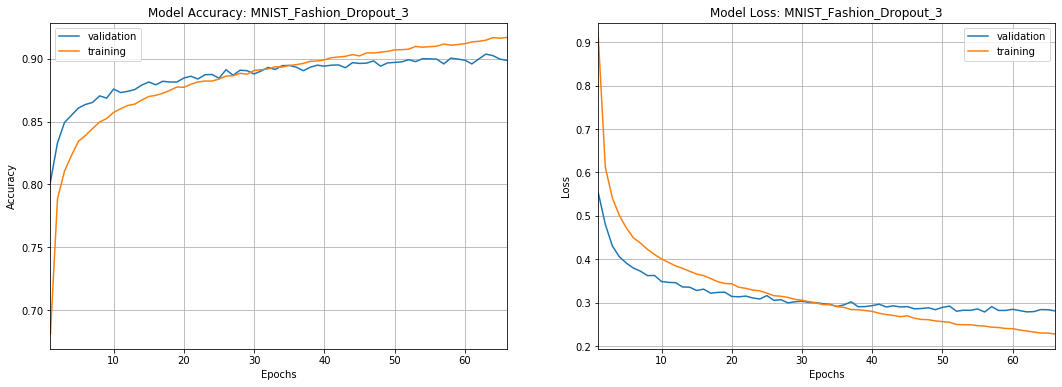

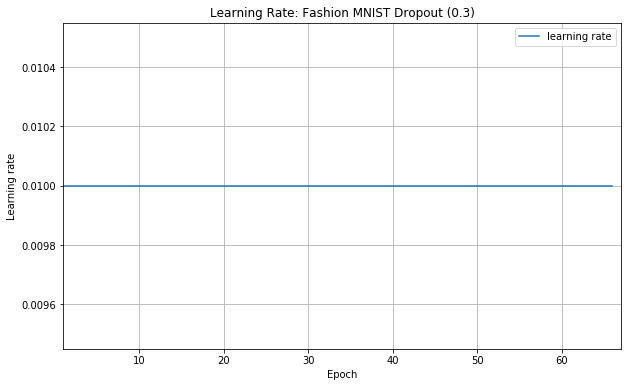

In [15]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_Dropout_3 = len(history_MNIST_Fashion_Dropout_3.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_Dropout_3)

test_loss_MNIST_Fashion_Dropout_3, test_accuracy_MNIST_Fashion_Dropout_3 = model_Dropout_3.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_Dropout_3))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_Dropout_3))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_Dropout_3 = model_Dropout_3.predict(X_test)
y_test_predicted_Dropout_3 = np.argmax(y_test_predicted_proba_Dropout_3, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_Dropout_3))


plot_learning_curves(history_MNIST_Fashion_Dropout_3, numOfEpochs_MNIST_Fashion_Dropout_3, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_Dropout_3, 
                   "Learning Rate: Fashion MNIST Dropout (0.3)")

## Experiment 5: Dropout: p = 0.4

In [16]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_Dropout_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    keras.layers.Dropout(rate=0.4),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_Dropout_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_4"
model_name_format = "MNIST_Fashion_Dropout_4.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_4 = model_Dropout_4.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_4_sec = t1-t0
duration_MNIST_Fashion_Dropout_4 = convertTime(duration_MNIST_Fashion_Dropout_4_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_4)
print("\n")


model_Dropout_4.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.9911 - accuracy: 0.6501 - val_loss: 0.5801 - val_accuracy: 0.7928
Epoch 2/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.6634 - accuracy: 0.7683 - val_loss: 0.4941 - val_accuracy: 0.8270
Epoch 3/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5821 - accuracy: 0.7949 - val_loss: 0.4460 - val_accuracy: 0.8428
Epoch 4/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5374 - accuracy: 0.8117 - val_loss: 0.4199 - val_accuracy: 0.8480
Epoch 5/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5062 - accuracy: 0.8232 - val_loss: 0.4054 - val_accuracy: 0.8566
Epoch 6/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4818 - accuracy: 0.8279 - val_loss: 0.3934 - val_accuracy: 0.8582
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2771 - accuracy: 0.8993 - val_loss: 0.2882 - val_accuracy: 0.8954
Epoch 56/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2749 - accuracy: 0.9004 - val_loss: 0.2879 - val_accuracy: 0.8972
Epoch 57/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2738 - accuracy: 0.9003 - val_loss: 0.2984 - val_accuracy: 0.8942
Epoch 58/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2720 - accuracy: 0.9005 - val_loss: 0.2873 - val_accuracy: 0.8994
Epoch 59/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2700 - accuracy: 0.9009 - val_loss: 0.2882 - val_accuracy: 0.8972
Epoch 60/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2700 - accuracy: 0.9012 - val_loss: 0.2918 - val_accuracy: 0.8960
Epoch 61/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2664 - ac

Epochs:  89

MNIST_Fashion_Dropout_4 Test Accuracy: 0.894
MNIST_Fashion_Dropout_4 Test Loss: 0.310

Test Confusion Matrix:
[[826   2  16  14   5   1 130   0   6   0]
 [  4 967   0  20   5   0   4   0   0   0]
 [ 11   0 810   8  99   1  71   0   0   0]
 [ 19   4  10 887  40   0  37   0   3   0]
 [  0   1  69  22 856   0  51   0   1   0]
 [  0   0   0   1   0 968   0  18   1  12]
 [ 91   1  83  24  57   0 738   0   6   0]
 [  0   0   0   0   0  19   0 964   0  17]
 [  2   2   1   6   4   2  10   3 970   0]
 [  0   0   0   0   0   6   1  38   0 955]]


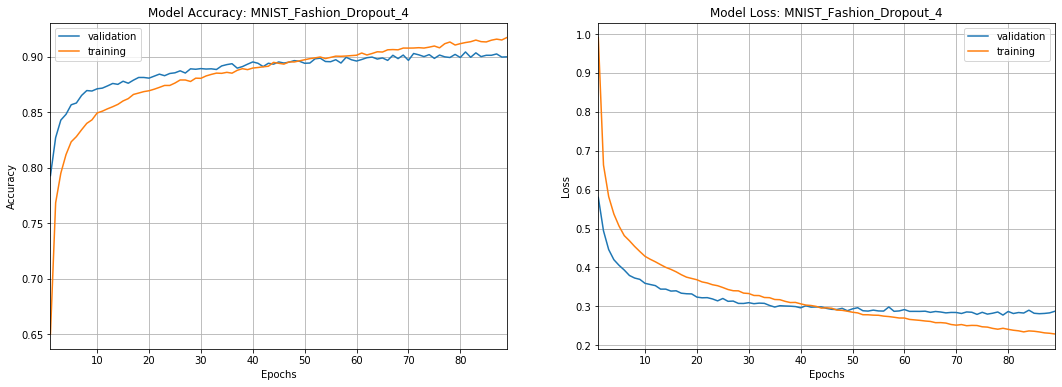

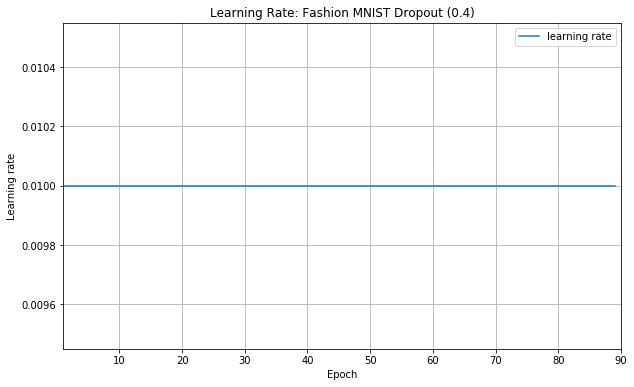

In [17]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_Dropout_4 = len(history_MNIST_Fashion_Dropout_4.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_Dropout_4)

test_loss_MNIST_Fashion_Dropout_4, test_accuracy_MNIST_Fashion_Dropout_4 = model_Dropout_4.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_Dropout_4))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_Dropout_4))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_Dropout_4 = model_Dropout_4.predict(X_test)
y_test_predicted_Dropout_4 = np.argmax(y_test_predicted_proba_Dropout_4, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_Dropout_4))


plot_learning_curves(history_MNIST_Fashion_Dropout_4, numOfEpochs_MNIST_Fashion_Dropout_4, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_Dropout_4, 
                   "Learning Rate: Fashion MNIST Dropout (0.4)")

## Experiment 6: Dropout: p = 0.5

In [18]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_Dropout_5 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    keras.layers.Dropout(rate=0.5),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_Dropout_5.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_5"
model_name_format = "MNIST_Fashion_Dropout_5.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_5 = model_Dropout_5.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_5_sec = t1-t0
duration_MNIST_Fashion_Dropout_5 = convertTime(duration_MNIST_Fashion_Dropout_5_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_5)
print("\n")


model_Dropout_5.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 76us/sample - loss: 1.0938 - accuracy: 0.6123 - val_loss: 0.6157 - val_accuracy: 0.7786
Epoch 2/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.7310 - accuracy: 0.7394 - val_loss: 0.5217 - val_accuracy: 0.8148
Epoch 3/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.6377 - accuracy: 0.7745 - val_loss: 0.4660 - val_accuracy: 0.8394
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5869 - accuracy: 0.7935 - val_loss: 0.4398 - val_accuracy: 0.8438
Epoch 5/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5511 - accuracy: 0.8085 - val_loss: 0.4226 - val_accuracy: 0.8520
Epoch 6/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5220 - accuracy: 0.8154 - val_loss: 0.4083 - val_accuracy: 0.8534
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3118 - accuracy: 0.8892 - val_loss: 0.2981 - val_accuracy: 0.8936
Epoch 56/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3083 - accuracy: 0.8902 - val_loss: 0.2950 - val_accuracy: 0.8954
Epoch 57/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3090 - accuracy: 0.8894 - val_loss: 0.3001 - val_accuracy: 0.8930
Epoch 58/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3053 - accuracy: 0.8917 - val_loss: 0.2973 - val_accuracy: 0.8958
Epoch 59/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3037 - accuracy: 0.8910 - val_loss: 0.2939 - val_accuracy: 0.8966
Epoch 60/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3053 - accuracy: 0.8903 - val_loss: 0.2995 - val_accuracy: 0.8930
Epoch 61/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3028 - ac

Epochs:  96

MNIST_Fashion_Dropout_5 Test Accuracy: 0.889
MNIST_Fashion_Dropout_5 Test Loss: 0.317

Test Confusion Matrix:
[[862   2  19  17   3   1  89   0   7   0]
 [  2 964   1  23   5   0   3   0   2   0]
 [ 15   1 815  10  94   1  62   1   1   0]
 [ 19   5   7 901  33   0  31   0   4   0]
 [  0   0  88  25 831   0  55   0   1   0]
 [  0   0   0   1   0 965   0  24   0  10]
 [131   1  93  27  69   0 667   0  12   0]
 [  0   0   0   0   0  16   0 960   0  24]
 [  1   1   3   7   1   3   9   4 971   0]
 [  0   0   0   0   0   5   1  41   0 953]]


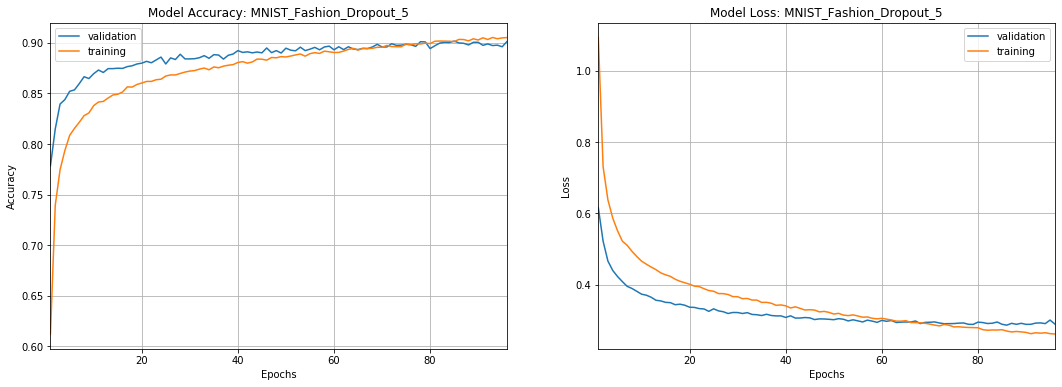

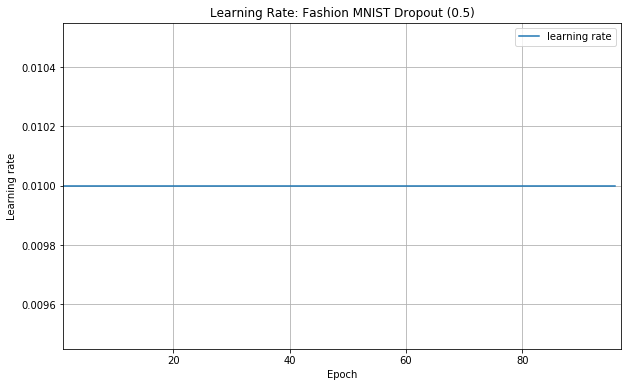

In [19]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_Dropout_5 = len(history_MNIST_Fashion_Dropout_5.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_Dropout_5)

test_loss_MNIST_Fashion_Dropout_5, test_accuracy_MNIST_Fashion_Dropout_5 = model_Dropout_5.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_Dropout_5))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_Dropout_5))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_Dropout_5 = model_Dropout_5.predict(X_test)
y_test_predicted_Dropout_5 = np.argmax(y_test_predicted_proba_Dropout_5, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_Dropout_5))


plot_learning_curves(history_MNIST_Fashion_Dropout_5, numOfEpochs_MNIST_Fashion_Dropout_5, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_Dropout_5, 
                   "Learning Rate: Fashion MNIST Dropout (0.5)")

## Experiment 7: Dropout: Last Hidden Layer p = 0.4

In [20]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal")
                        
model_LastLayer = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(10, activation="softmax")
])


'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(lr=1e-2)


'''
# Compile the model
'''
model_LastLayer.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_cb = LossHistory()


model_name = "MNIST_Fashion_Dropout_LastLayer"
model_name_format = "MNIST_Fashion_Dropout_LastLayer.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 32

t0 = time.time()
history_MNIST_Fashion_Dropout_LastLayer = model_LastLayer.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_MNIST_Fashion_Dropout_LastLayer_sec = t1-t0
duration_MNIST_Fashion_Dropout_LastLayer = convertTime(duration_MNIST_Fashion_Dropout_LastLayer_sec)
print("\nTraining Time: ", duration_MNIST_Fashion_Dropout_LastLayer)
print("\n")


model_LastLayer.save(model_name_format)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.8340 - accuracy: 0.7210 - val_loss: 0.5358 - val_accuracy: 0.8178
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.5630 - accuracy: 0.8089 - val_loss: 0.4641 - val_accuracy: 0.8374
Epoch 3/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.5002 - accuracy: 0.8273 - val_loss: 0.4180 - val_accuracy: 0.8532
Epoch 4/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.4667 - accuracy: 0.8374 - val_loss: 0.3987 - val_accuracy: 0.8590
Epoch 5/100
55000/55000 [==============================] - 4s 64us/sample - loss: 0.4441 - accuracy: 0.8447 - val_loss: 0.3875 - val_accuracy: 0.8644
Epoch 6/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.4265 - accuracy: 0.8494 - val_loss: 0.3774 - val_accuracy: 0.8640
Epoch 7/100
55000/55000 [==========================

Epochs:  52

MNIST_Fashion_Dropout_LastLayer Test Accuracy: 0.885
MNIST_Fashion_Dropout_LastLayer Test Loss: 0.317

Test Confusion Matrix:
[[827   2  17  25   3   1 113   0  12   0]
 [  4 962   1  23   4   0   5   0   1   0]
 [ 12   1 798  14  85   1  86   0   3   0]
 [ 17   5  14 916  15   0  28   0   5   0]
 [  1   0  87  53 790   0  66   0   3   0]
 [  0   0   0   1   0 962   0  25   2  10]
 [106   1  69  30  60   0 721   0  13   0]
 [  0   0   0   0   0  20   0 944   1  35]
 [  4   0   1   7   2   2   8   5 971   0]
 [  0   0   0   0   0   9   1  30   0 960]]


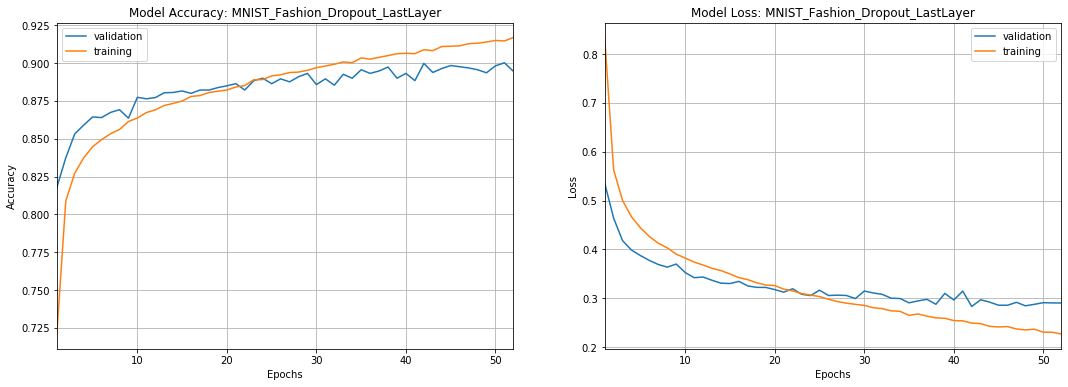

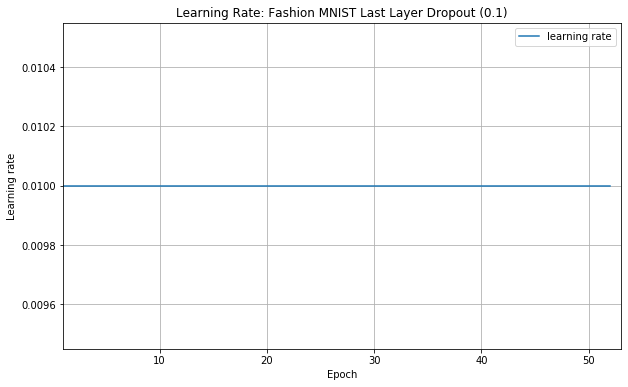

In [21]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)


numOfEpochs_MNIST_Fashion_LastLayer = len(history_MNIST_Fashion_Dropout_LastLayer.history['loss'])
print("Epochs: ", numOfEpochs_MNIST_Fashion_LastLayer)

test_loss_MNIST_Fashion_LastLayer, test_accuracy_MNIST_Fashion_LastLayer = model_LastLayer.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_MNIST_Fashion_LastLayer))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_MNIST_Fashion_LastLayer))



# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted_proba_LastLayer = model_LastLayer.predict(X_test)
y_test_predicted_LastLayer = np.argmax(y_test_predicted_proba_LastLayer, axis=1) # get the label/index of the highest probability class



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_LastLayer))


plot_learning_curves(history_MNIST_Fashion_Dropout_LastLayer, numOfEpochs_MNIST_Fashion_LastLayer, 
                     model_name)


plot_learning_rate(loss_history_cb, numOfEpochs_MNIST_Fashion_LastLayer, 
                   "Learning Rate: Fashion MNIST Last Layer Dropout (0.1)")

## Comparison of Validation Accuracy Over Epochs

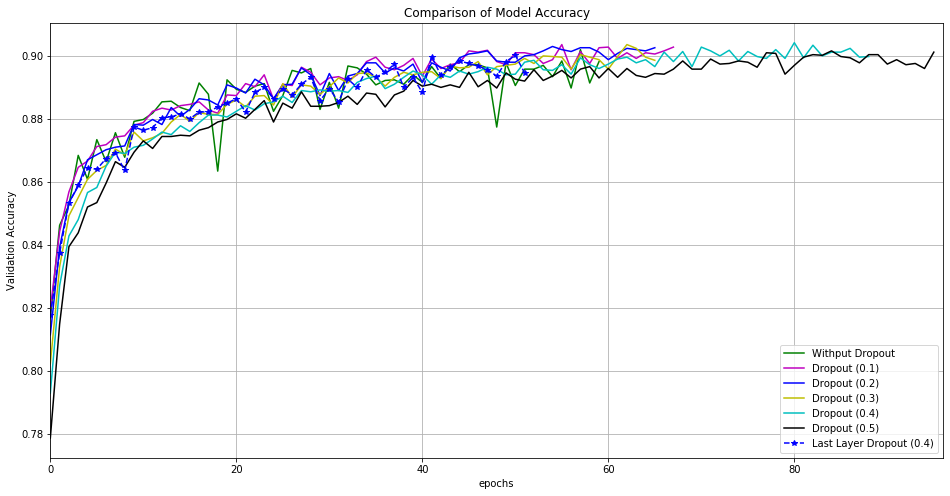

In [23]:
epochs = max(numOfEpochs_MNIST_Fashion_No_Dropout, numOfEpochs_MNIST_Fashion_Dropout_1, 
            numOfEpochs_MNIST_Fashion_Dropout_2, numOfEpochs_MNIST_Fashion_Dropout_3,
            numOfEpochs_MNIST_Fashion_Dropout_4, numOfEpochs_MNIST_Fashion_Dropout_5,
            numOfEpochs_MNIST_Fashion_LastLayer)

plt.figure(figsize=(16,8))

plt.plot(range(numOfEpochs_MNIST_Fashion_No_Dropout),history_MNIST_Fashion_No_Dropout.history['val_accuracy'],'g-',
         label='Withput Dropout')


plt.plot(range(numOfEpochs_MNIST_Fashion_Dropout_1),history_MNIST_Fashion_Dropout_1.history['val_accuracy'],'m-',
         label='Dropout (0.1)')


plt.plot(range(numOfEpochs_MNIST_Fashion_Dropout_2),history_MNIST_Fashion_Dropout_2.history['val_accuracy'],'b-',
         label='Dropout (0.2)')


plt.plot(range(numOfEpochs_MNIST_Fashion_Dropout_3),history_MNIST_Fashion_Dropout_3.history['val_accuracy'],'y-',
         label='Dropout (0.3)')


plt.plot(range(numOfEpochs_MNIST_Fashion_Dropout_4),history_MNIST_Fashion_Dropout_4.history['val_accuracy'],'c-',
         label='Dropout (0.4)')


plt.plot(range(numOfEpochs_MNIST_Fashion_Dropout_5),history_MNIST_Fashion_Dropout_5.history['val_accuracy'],'k-',
         label='Dropout (0.5)')


plt.plot(range(numOfEpochs_MNIST_Fashion_LastLayer),history_MNIST_Fashion_Dropout_LastLayer.history['val_accuracy'],'b*--',
         label='Last Layer Dropout (0.4)')




plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [24]:
data = [
    ["Without Dropout", numOfEpochs_MNIST_Fashion_No_Dropout, duration_MNIST_Fashion_No_Dropout, 
     test_accuracy_MNIST_Fashion_No_Dropout],
    ["Dropout (0.1)", numOfEpochs_MNIST_Fashion_Dropout_1, duration_MNIST_Fashion_Dropout_1, 
     test_accuracy_MNIST_Fashion_Dropout_1],
    ["Dropout (0.2)", numOfEpochs_MNIST_Fashion_Dropout_2, duration_MNIST_Fashion_Dropout_2, 
     test_accuracy_MNIST_Fashion_Dropout_2],
    ["Dropout (0.3)", numOfEpochs_MNIST_Fashion_Dropout_3, duration_MNIST_Fashion_Dropout_3, 
     test_accuracy_MNIST_Fashion_Dropout_3],
    ["Dropout (0.4)", numOfEpochs_MNIST_Fashion_Dropout_4, duration_MNIST_Fashion_Dropout_4, 
     test_accuracy_MNIST_Fashion_Dropout_4],
    ["Dropout (0.5)", numOfEpochs_MNIST_Fashion_Dropout_5, duration_MNIST_Fashion_Dropout_5, 
     test_accuracy_MNIST_Fashion_Dropout_5],
    ["Last Layer Dropout (0.4)", numOfEpochs_MNIST_Fashion_LastLayer, duration_MNIST_Fashion_Dropout_LastLayer, 
     test_accuracy_MNIST_Fashion_LastLayer]
    
       ]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,Without Dropout,60,3 min 27 s,0.8888
1,Dropout (0.1),68,4 min 18 s,0.8920
2,Dropout (0.2),66,4 min 10 s,0.8897
3,Dropout (0.3),66,4 min 9 s,0.8904
4,Dropout (0.4),89,5 min 33 s,0.8941
5,Dropout (0.5),96,6 min 33 s,0.8889
6,Last Layer Dropout (0.4),52,3 min 11 s,0.8851


## Observation: Effect of Dropout to Reduce Overfitting

We see that Dropout increases test accuracy by reducing overfitting. However, it converges slowly. The number of epochs increases with the dropout rate.

Notice that achieving the optimal test accuracy via Dropout requires careful tuning of the dropout rate. We get largest test accuracy from 0.4 dropout rate in all hidden layers.

## Capturing Prediction Uncertainty: Monte Carlo (MC) Dropout

To implement MC Dropout we perform following three tasks: 
- Make 500 predictions over the test set. We use the best Dropout model, i.e., with dropout rate 0.4 for all hidden layers, to make predictions.
- In the Dropout based pretrained mode, set the parameter training=True for ensuring that the Dropout layer is active during making predictions.
- Stack the predictions. 


Since we have 10,000 test data and 10 classes, a single prediction is given in a $10000 \times 10$ matrix. MC Droput makes 500 such predictions. Thus, there would be 500 matrices each of dimension $10000 \times 10$ .

After stacking these matrices, we get a new matrix (denoted by y_probas) of shape [500, 10000, 10].

We average over the first dimension to create a new matrix (denoted by y_proba) of dimension $10000 \times 10$.


In [25]:
%time y_probas = np.stack([model_Dropout_4(X_test, training=True) for sample in range(500)])
y_proba = y_probas.mean(axis=0)

CPU times: user 2min 23s, sys: 52.2 s, total: 3min 15s
Wall time: 38.4 s


In [26]:
print("Shape of the stacked matrix with 500 predictions: ", y_probas.shape)
print("Shape of the averaged matrix: ", y_proba.shape)

Shape of the stacked matrix with 500 predictions:  (500, 10000, 10)
Shape of the averaged matrix:  (10000, 10)


## Making Predictions using the MC Dropout Technique

We use the averaged prediction matrix, created by the MC Dropout technique, to make new predictions for the test data.

In [27]:
y_pred = np.argmax(y_proba, axis=1)

mc_accuracy = np.sum(y_pred == y_test) / len(y_test)
print("MC Dropout Test Accuracy: ", mc_accuracy)

print("\nPlain Dropout Test Accuracy: ", test_accuracy_MNIST_Fashion_Dropout_4)

MC Dropout Test Accuracy:  0.8932

Plain Dropout Test Accuracy:  0.8941


## Measuring Uncertainty using MC Dropout

Although the average test accuracies obtained from the MC dropout and plain Dropout technique do not vary much, the MC Dropout technique is able to capture model's uncertainty.

Below we compute the mean and standard deviation of the entropy for the prediction probabilities generated by the MC Dropout and plain Dropout techniques. We see that the uncertainty of the MC Dropout predictions is larger.

In [28]:
no_mc_entropy_list = []

mc_entropy_list = []

for i in range(len(y_test)):
    
    no_mc_entropy = entropy(y_test_predicted_proba_Dropout_4[i])  
    no_mc_entropy_list.append(no_mc_entropy)
    
    
    mc_entropy = entropy(y_proba[i])
    mc_entropy_list.append(mc_entropy)

        
print("MC Dropout - Entropy Mean : ", np.mean(mc_entropy_list))
print("MC Dropout - Entropy STD: ", np.std(mc_entropy_list))


print("\nPlain Dropout - Entropy Mean : ", np.mean(no_mc_entropy_list))
print("Plain Dropout - Entropy STD: ", np.std(no_mc_entropy_list))



MC Dropout - Entropy Mean :  0.35652775
MC Dropout - Entropy STD:  0.40251106

Plain Dropout - Entropy Mean :  0.2538574
Plain Dropout - Entropy STD:  0.35368592
